## Importing Libraries

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set Hugging Face cache directory
import os
os.environ["HF_HOME"] = "D:/pytorch_project/huggingface_cache"
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification

## Reading Data

In [2]:
df = pd.read_csv('../data/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', header=None)

In [3]:
df, _ = train_test_split(df, train_size=20000, stratify=df[0], random_state=42)
df = df.reset_index(drop=True)

In [4]:
df.head()

,0,1,2,3,4,5
0,0,1985165238,Sun May 31 16:33:48 PDT 2009,NO_QUERY,nikkistarshine,There is this sweater that I had all of freshm...
1,0,2016276574,Wed Jun 03 06:29:43 PDT 2009,NO_QUERY,livewire89,"@mel161278 - hey hun, I'm good hows you? I'm s..."
2,0,2250106772,Fri Jun 19 23:43:10 PDT 2009,NO_QUERY,siaan,@redvers he never cried thru pain but he was c...
3,4,2062786014,Sun Jun 07 00:17:35 PDT 2009,NO_QUERY,justinstanford,FireID finally launches in the Apple iPhone Ap...
4,0,2265776466,Sun Jun 21 07:17:12 PDT 2009,NO_QUERY,rkuhonta,Lost at tennis tournament in Park Homes becaus...


In [5]:
df.shape

(20000, 6)

In [6]:
df[0].value_counts().sort_index()

0
0    10000
4    10000
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       20000 non-null  int64 
 1   1       20000 non-null  int64 
 2   2       20000 non-null  object
 3   3       20000 non-null  object
 4   4       20000 non-null  object
 5   5       20000 non-null  object
dtypes: int64(2), object(4)
memory usage: 937.6+ KB


In [8]:
df.describe()

,0,1
count,20000.00000,2.000000e+04
mean,2.00000,1.999655e+09
std,2.00005,1.939782e+08
min,0.00000,1.467816e+09
25%,0.00000,1.956661e+09
50%,2.00000,2.002628e+09
75%,4.00000,2.177751e+09
max,4.00000,2.329205e+09


## Data Preprocessing and Cleaning

In [9]:
df.isna().sum().sum()

np.int64(0)

In [10]:
print(df.columns)

Index([0, 1, 2, 3, 4, 5], dtype='int64')


In [11]:
df[5].iloc[3]

'FireID finally launches in the Apple iPhone Appstore! Congrats team  event:http://tinyurl.com/nqzz52'

In [12]:
df.drop(columns=[1, 2, 3, 4], inplace=True)

In [13]:
df.columns = ['target', 'text']

In [14]:
df.head()

,target,text
0,0,There is this sweater that I had all of freshm...
1,0,"@mel161278 - hey hun, I'm good hows you? I'm s..."
2,0,@redvers he never cried thru pain but he was c...
3,4,FireID finally launches in the Apple iPhone Ap...
4,0,Lost at tennis tournament in Park Homes becaus...


In [15]:
df['target'].value_counts()

target
0    10000
4    10000
Name: count, dtype: int64

In [16]:
df['target'] = df['target'].map({0: 0, 4: 1})
df['target'].value_counts()

target
0    10000
1    10000
Name: count, dtype: int64

## Clean text function

In [17]:
def clean_text(text):
    text = re.sub(r"http\S+|www\S+", '', text)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)        # Remove mentions and hashtags
    text = re.sub(r'\s+', ' ', text).strip()    # Remove extra whitespaces
    return text

In [18]:
df['text'] = df['text'].apply(clean_text)

In [19]:
df['text'][3]

'FireID finally launches in the Apple iPhone Appstore! Congrats team event:'

In [20]:
df.head()

,target,text
0,0,There is this sweater that I had all of freshm...
1,0,"- hey hun, I'm good hows you? I'm still trying..."
2,0,he never cried thru pain but he was crying and...
3,1,FireID finally launches in the Apple iPhone Ap...
4,0,Lost at tennis tournament in Park Homes becaus...


In [21]:
X = df.drop('target', axis=1)
y = df['target']

## Train/validation/test split

In [22]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

## Load tokenizer

In [23]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

## Define custom dataset

In [24]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [25]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Create datasets and dataloaders

In [26]:
train_dataset = SentimentDataset(X_train['text'], y_train.tolist(), tokenizer)
val_dataset = SentimentDataset(X_val['text'], y_val.tolist(), tokenizer)
test_dataset = SentimentDataset(X_test['text'], y_test.tolist(), tokenizer)

In [27]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## Load model

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.000002)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Training and validation loop

In [29]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
patience = 1
counter = 0
best_model_path = '../my_model/'

epochs = 7
    
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    total_steps = len(train_loader)

    print(f"\nEpoch {epoch + 1}/{epochs}")

    for step, batch in enumerate(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Training Progress (per batch)
        if (step + 1) % 20 == 0 or (step + 1) == total_steps:
            print(f"[{step + 1}/{total_steps}] Batch Loss: {loss.item():.4f} | Running Accuracy: {correct / total:.4f}")

         # Train metrics for epoch
    avg_train_loss = total_loss / total_steps
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0


    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=inputs, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"\n[Epoch {epoch + 1}] Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"[Epoch {epoch + 1}] Val   Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    # Saving the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained(best_model_path)
        print(f"✅ Model saved (val_loss improved to {best_val_loss:.4f})")
        counter = 0
    else:
        counter += 1
        print(f"⏳ No improvement in val_loss for {counter} epoch(s)")

        if counter >= patience:
            print(f"⛔ Early stopping triggered after {patience} epochs without improvement.")
            break


Epoch 1/7
[20/375] Batch Loss: 0.6981 | Running Accuracy: 0.4859
[40/375] Batch Loss: 0.6968 | Running Accuracy: 0.5055
[60/375] Batch Loss: 0.6810 | Running Accuracy: 0.5245
[80/375] Batch Loss: 0.6883 | Running Accuracy: 0.5457
[100/375] Batch Loss: 0.6706 | Running Accuracy: 0.5572
[120/375] Batch Loss: 0.6680 | Running Accuracy: 0.5711
[140/375] Batch Loss: 0.6459 | Running Accuracy: 0.5806
[160/375] Batch Loss: 0.6529 | Running Accuracy: 0.5914
[180/375] Batch Loss: 0.6266 | Running Accuracy: 0.6033
[200/375] Batch Loss: 0.6286 | Running Accuracy: 0.6142
[220/375] Batch Loss: 0.5748 | Running Accuracy: 0.6227
[240/375] Batch Loss: 0.6570 | Running Accuracy: 0.6302
[260/375] Batch Loss: 0.5718 | Running Accuracy: 0.6387
[280/375] Batch Loss: 0.5224 | Running Accuracy: 0.6481
[300/375] Batch Loss: 0.6015 | Running Accuracy: 0.6551
[320/375] Batch Loss: 0.4736 | Running Accuracy: 0.6626
[340/375] Batch Loss: 0.5916 | Running Accuracy: 0.6689
[360/375] Batch Loss: 0.5206 | Running Ac

## 📈 Model Performance during Training

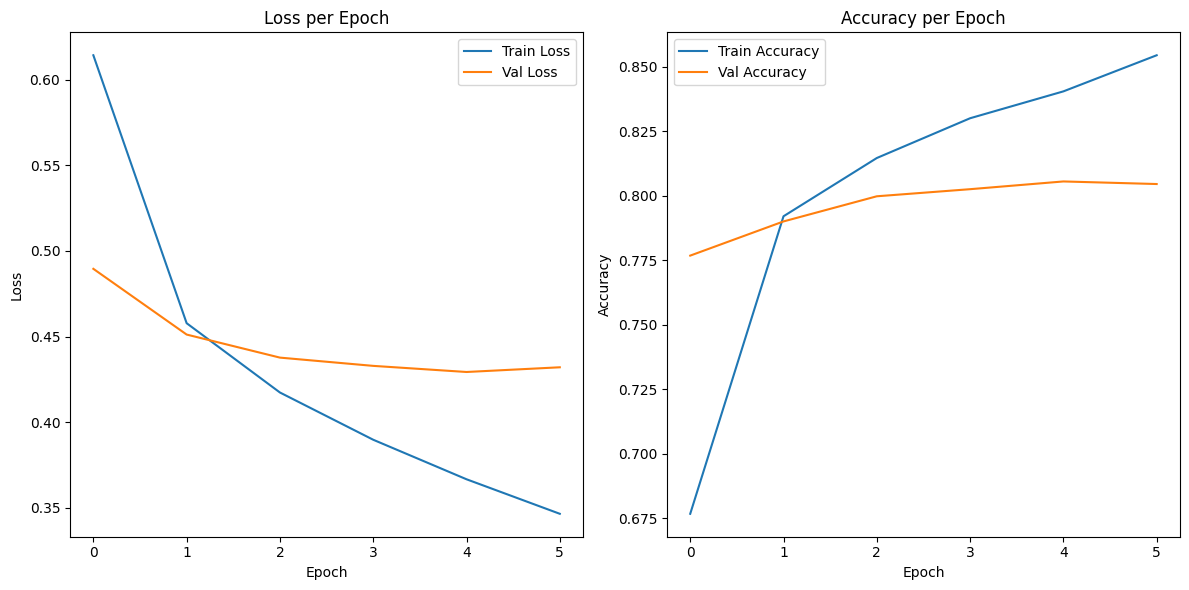

In [30]:
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
model.eval()
test_loss = 0
test_correct = 0
test_total = 0

all_preds = []
all_labels = []
all_probs = []

# Load the best model before testing
model.from_pretrained(best_model_path)
model.eval()

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        test_loss += loss.item()
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())

        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total

precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')
roc_auc = roc_auc_score(all_labels, all_probs)


print(f"\nTest Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")


Test Loss: 0.4321
Test Accuracy: 0.8070
Precision: 0.7880
Recall:    0.8400
F1 Score:  0.8132
ROC AUC:   0.8910


## Confusion Matrix

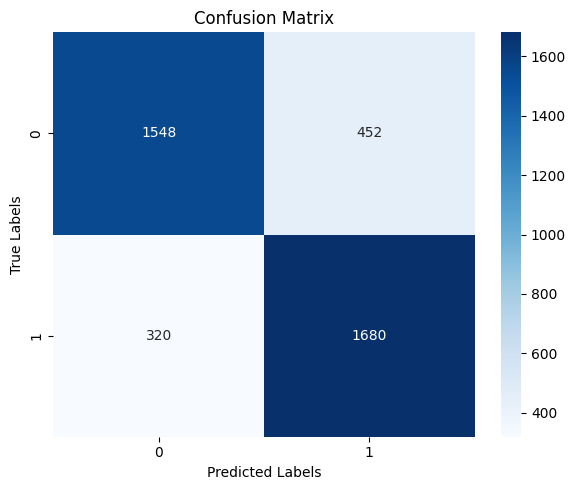

In [33]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [34]:
def predict_sentiment(text):
    model.eval()


    def clean_text(text):
        text = re.sub(r"http\S+|www\S+", '', text)
        text = re.sub(r'\@\w+|\#', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    cleaned_text = clean_text(text)


    inputs = tokenizer(cleaned_text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}


    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()
        confidence = F.softmax(logits, dim=1)[0][predicted_class].item()

    label = "Positive 😊" if predicted_class == 1 else "Negative 😠"
    return label, confidence

In [35]:
text = "on this week i'll cook cake"
label, conf = predict_sentiment(text)
print(f"Prediction: {label} (Confidence: {conf:.2f})")

Prediction: Positive 😊 (Confidence: 0.97)
